In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from matplotlib.colors import LogNorm
from scipy.integrate import odeint
sns.set_context("talk", font_scale=1.4)

## Compute the temporal development from the transition matrix
### Load some data

In [4]:
# load the transition matrix
P_allCountries_Bayes = np.genfromtxt('./../results/transitionBayesAllCountries.csv')

In [5]:
# Load the time series for plotting empirical distributions
timeSeries = pd.read_excel('./../data/polity5/p5v2018.xls')
# do some cleaning
timeSeries = timeSeries.dropna(subset=['year', 'country', 'polity2'])

### Actual computations

In [6]:
# Get the distribution for the year 2018
currentScores=timeSeries[timeSeries['year']==2018]['polity2']
[counts2018,bins] = np.histogram(currentScores,bins=np.arange(-10,12))
density2018 = counts2018/np.sum(counts2018)

In [7]:
# iterate over years 

tMax = 750

# forward
x=np.zeros((21,tMax))
x[:,0]=density2018
for t in np.arange(tMax-1):
    x[:,t+1]= x[:,t].dot(P_allCountries_Bayes)

In [12]:
# We also need the steady state again for the illustration
def computeSteadyStateEV(transitionMatrix):
    # compute it as eigenvector
    valsT, vecsT = np.linalg.eig(transitionMatrix.transpose())
    
    # find the index of the eigenvalue closest to 1
    index_ev1 = (np.abs(valsT - 1)).argmin()
    
    v = vecsT[:,index_ev1]
    return((v/np.sum(v)).real) # normalise it for the return and also ignore the imaginary part (from numerical approx.)



steadyStateB = computeSteadyStateEV(P_allCountries_Bayes)

## Illustrations

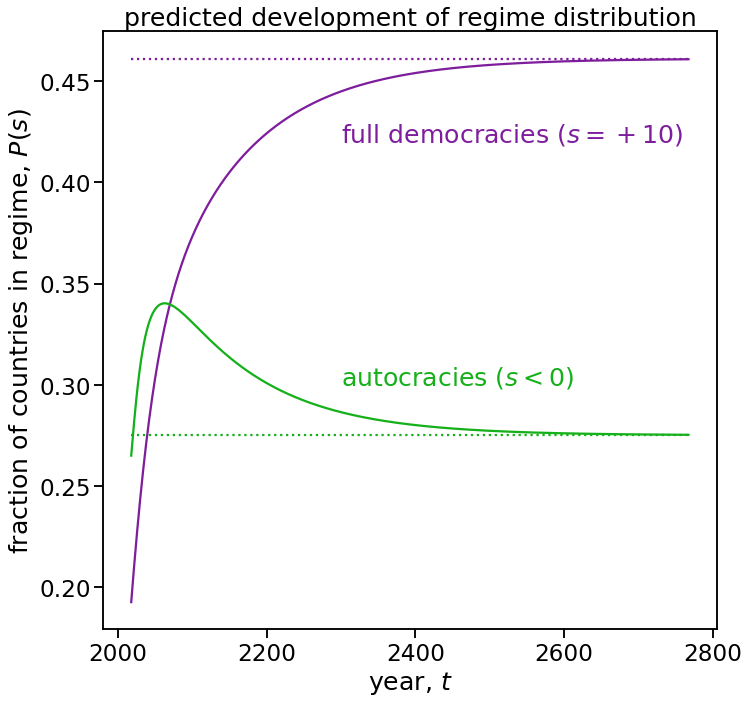

In [19]:
plt.figure(figsize=(11,11))
# plot the full democracy fraction
plt.plot(np.arange(2018, 2018+ tMax),x[20,:],c=sns.xkcd_rgb['purple'])

# plot the autocracies
autocraty = np.sum(x[0:10,:],axis=0)
plt.plot(np.arange(2018, 2018+ tMax),autocraty,c=sns.xkcd_rgb['green'])


# Plot steady state lines
plt.hlines(y=steadyStateB[20],xmin=2018,xmax=2018+tMax,linestyles='dotted',color=sns.xkcd_rgb['purple'])
plt.hlines(y=np.sum(steadyStateB[0:10]),xmin=2018,xmax=2018+tMax,linestyles='dotted',color=sns.xkcd_rgb['green'])


# add labels
plt.text(x=2300,y=0.3,s=r'autocracies ($s<0$)',color=sns.xkcd_rgb['green'])
plt.text(x=2300,y=0.42,s=r'full democracies ($s=+10$)',color=sns.xkcd_rgb['purple'])
plt.xlabel(r'year, $t$')
plt.ylabel(r'fraction of countries in regime, $P(s)$')
plt.title('predicted development of regime distribution')
plt.savefig('./../results/figures/Fig5-predictedDevelopment.pdf')


In [9]:
# Load the time series for plotting empirical distributions
timeSeries = pd.read_excel('./../data/polity5/p5v2018.xls')
# do some cleaning
timeSeries = timeSeries.dropna(subset=['year', 'country', 'polity2'])

In [10]:
# plot the distribution at earlier times
[hist1800,binEdges ] = np.histogram(timeSeries[timeSeries['year']==1800]['polity2'],np.arange(-10,12))
[hist1900,binEdges ] = np.histogram(timeSeries[timeSeries['year']==1900]['polity2'],np.arange(-10,12))
[hist2000,binEdges ] = np.histogram(timeSeries[timeSeries['year']==2000]['polity2'],np.arange(-10,12))
[hist2018,binEdges ] = np.histogram(timeSeries[timeSeries['year']==2018]['polity2'],np.arange(-10,12))

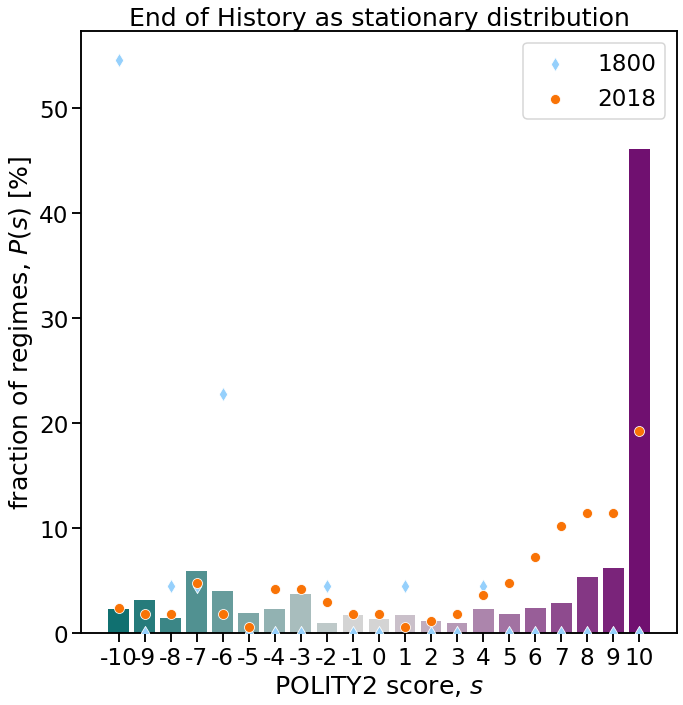

In [14]:
# plot the steady state
plt.figure(figsize=(10,10))
steadyState=pd.DataFrame()
steadyState['fraction'] = 100*steadyStateEV
steadyState['regime'] = np.arange(-10,11,1)

teal = [0,0.5,0.5]
lightgray = [0.83,0.83,0.83]
purple = [0.5,0.0,0.5]

clrs = [teal,lightgray,purple]
clrs1 = np.linspace(teal, lightgray, 10, axis=1)
clrs2 = np.linspace(lightgray, purple, 11, axis=1)

clrs = np.concatenate((clrs1,clrs2), axis=1)

clrsL = np.transpose(clrs).tolist()


g=sns.barplot(x="regime", y="fraction", data=steadyState,palette=clrsL)


sns.scatterplot(x=np.arange(0,21),y=100*hist1800/np.sum(hist1800),marker='d',color=sns.xkcd_rgb['light blue'], s=100,zorder=10,label=r'1800')
sns.scatterplot(x=np.arange(0,21),y=100*hist2018/np.sum(hist2018),marker='o',color=sns.xkcd_rgb['orange'], s=100, zorder=11,label=r'2018')
plt.legend(loc=0)
plt.tight_layout()
plt.title('End of History as stationary distribution')
plt.xlabel(r'POLITY2 score, $s$')
plt.ylabel(r'fraction of regimes, $P(s)$ [$\%$]')
#plt.savefig('./figures/distributionAndSteadyStateBarplot.pdf')
plt.savefig('./../results/supplementaryFigures/Fig4-distributionAndSteadyStateBarplot.pdf')




In [16]:
def distributionsForYear(timeSeriesData,year):
    currentScores=timeSeriesData[timeSeriesData['year']==year]['polity2']
    [countsYear,bins] = np.histogram(currentScores,bins=np.arange(-10,12))
    densityYear = countsYear/np.sum(countsYear)
    return(densityYear)



In [17]:
currentScores=timeSeries[timeSeries['year']==2018]['polity2']
[counts2018,bins] = np.histogram(currentScores,bins=np.arange(-10,12))
density2018 = counts2018/np.sum(counts2018)

In [18]:
#np.linalg.inv(P_allCountries)

(P_allCountries.transpose())*P_allCountries

array([[9.52634488e-01, 1.83177142e-05, 2.17751067e-05, 9.87233833e-06,
        3.34652422e-06, 0.00000000e+00, 1.92561355e-06, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 3.79272745e-06, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.83177142e-05, 8.74919243e-01, 5.58545750e-04, 4.74809896e-05,
        3.25153554e-05, 1.15677145e-05, 1.57160337e-05, 3.64204523e-06,
        0.00000000e+00, 0.00000000e+00, 2.65325300e-05, 0.00000000e+00,
        4.99064255e-05, 3.11915159e-06, 0.00000000e+00, 1.73976583e-06,
        9.40785399e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [2.17751067e-05, 5.58545750e-04, 7.80962683e-01, 2.42647153e-04,
        3.60756608e-05, 1.28343344e-05, 2.49098264e-06, 6.46533610e-06,
        0.00000000e+00, 1.10741971e-05, 2.45314493e-05, 0.00000000e+00,
        5.5370

In [24]:
# iterate over years 

tMax = 750

# forward
x=np.zeros((21,tMax))
x[:,0]=density2018
for t in np.arange(tMax-1):
    x[:,t+1]= x[:,t].dot(P_allCountries_Bayes)

# # backwards
# backTransition=P_allCountries.transpose()
# xBack=np.zeros((21,tMax))
# xBack[:,0]=density2018
# for t in np.arange(tMax-1):
#     xBack[:,t+1]= xBack[:,t].dot(backTransition)

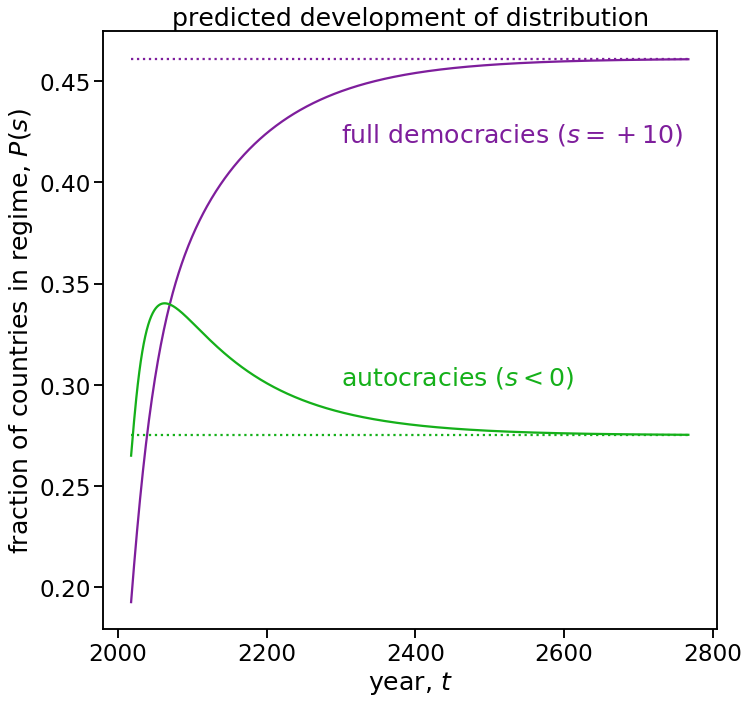

In [28]:
plt.figure(figsize=(11,11))


plt.plot(np.arange(2018, 2018+ tMax),x[20,:],c=sns.xkcd_rgb['purple'])

autocraty = np.sum(x[0:10,:],axis=0)
plt.plot(np.arange(2018, 2018+ tMax),autocraty,c=sns.xkcd_rgb['green'])


# partialDemocracy = np.sum(x[10:19,:],axis=0)
# plt.plot(np.arange(2018, 2018+ tMax),partialDemocracy,c=sns.xkcd_rgb['light purple'])

# anocracy = np.sum(x[6:16,:],axis=0)
# plt.plot(np.arange(2018, 2018+ tMax),anocracy,c=sns.xkcd_rgb['red'])
# plt.plot(np.arange(2018, 2018+ tMax),x[0,:])
plt.hlines(y=steadyStateB[20],xmin=2018,xmax=2018+tMax,linestyles='dotted',color=sns.xkcd_rgb['purple'])
#plt.hlines(y=0.99*steadyState[20],xmin=2018,xmax=2018+tMax,linestyles='dotted')

plt.hlines(y=np.sum(steadyStateB[0:10]),xmin=2018,xmax=2018+tMax,linestyles='dotted',color=sns.xkcd_rgb['green'])


# add the historical data
years = np.append(np.arange(1800,2018,20),2018)
historicDistributions = np.zeros((len(years),3))
i=0
for y in years:
    densityThisYear = distributionsForYear(timeSeries,y)
    # save the data for full democracies
    historicDistributions[i,0] = densityThisYear[20]
    # and for autocracies
    historicDistributions[i,1] = np.sum(densityThisYear[0:10])
    # and for partial democracies
    historicDistributions[i,2] = np.sum(densityThisYear[10:19])
    i=i+1

# plt.scatter(years,historicDistributions[:,0],color=sns.xkcd_rgb['purple'])
# plt.scatter(years,historicDistributions[:,1],color=sns.xkcd_rgb['green'])
# #plt.scatter(years,historicDistributions[:,2],color=sns.xkcd_rgb['light purple'])

plt.text(x=2300,y=0.3,s=r'autocracies ($s<0$)',color=sns.xkcd_rgb['green'])
plt.text(x=2300,y=0.42,s=r'full democracies ($s=+10$)',color=sns.xkcd_rgb['purple'])

plt.xlabel(r'year, $t$')
plt.ylabel(r'fraction of countries in regime, $P(s)$')
plt.title('predicted development of distribution')
plt.savefig('./figures/predictedDevelopment_v3.pdf')

In [37]:
np.append(years,2018)

array([1800, 1820, 1840, 1860, 1880, 1900, 1920, 1940, 1960, 1980, 2000,
       2018])

In [31]:
np.where(autocraty-x[20,:]<0)[0][0]+2018

2070

In [32]:
np.max(autocraty)

0.3402494968249496

In [33]:
np.argmax(autocraty)+2018

2063

In [47]:
np.where((steadyStateB[20]-x[20,:])<0.01)[0][0]

342

In [48]:
342 + 2018

2360

In [45]:
steadyStateB[21]

IndexError: index 21 is out of bounds for axis 0 with size 21

In [173]:
# prediction from 1800 onwards

In [172]:
scores1800=timeSeries[timeSeries['year']==1800]['polity2']
[counts1800,bins] = np.histogram(scores1800,bins=np.arange(-10,12))
density1800 = counts1800/np.sum(counts1800)

In [193]:
tMax = 500

# forward
x1800=np.zeros((21,tMax))
x1800[:,0]=density1800
for t in np.arange(tMax-1):
    x1800[:,t+1]= x1800[:,t].dot(P_allCountries)

In [194]:

tVec=np.arange(1800,2018,10)
    
nT=len(tVec)

scoresYears=np.zeros((21,nT))

i=0
for t in tVec:
    scoresThisT=timeSeries[timeSeries['year']==t]['polity2']
    [countsThisT,bins] = np.histogram(scoresThisT,bins=np.arange(-10,12))
    densityThisT = countsThisT/np.sum(countsThisT)
    scoresYears[:,i] = densityThisT
    i=i+1

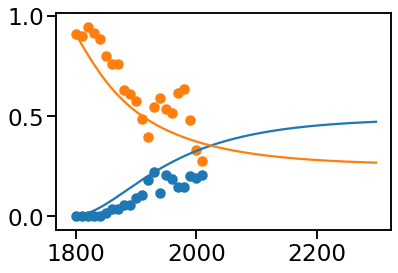

In [195]:
plt.plot(np.arange(1800, 1800+ tMax),x1800[20,:])


autocraty = autocraty = np.sum(x1800[0:10,:],axis=0)
plt.plot(np.arange(1800, 1800+ tMax),autocraty)

autocratyData = np.sum(scoresYears[0:10,:],axis=0)
plt.scatter(tVec,scoresYears[20,:])
plt.scatter(tVec,autocratyData)


#plt.plot(np.arange(2018, 2018+ tMax),x[0,:])
#plt.hlines(y=steadyState[20],xmin=2018,xmax=2018+tMax,linestyles='dotted')
#plt.hlines(y=0.99*steadyState[20],xmin=2018,xmax=2018+tMax,linestyles='dotted')


#plt.hlines(y=np.sum(steadyState[0:10]),xmin=2018,xmax=2018+tMax,linestyles='dotted')


In [186]:
len(scoresYears[20,:])

22

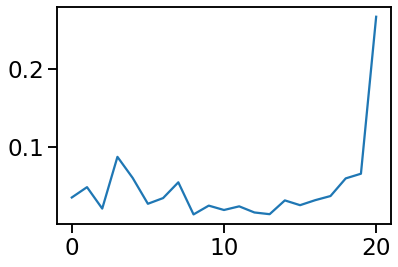

In [250]:
#

timeSeriesTemp = timeSeries[timeSeries['year']>1000]

P_allCountries = estimateTransitionMatrix(timeSeriesTemp)

steadyState = computeSteadyStateBruteForce(P_allCountries,10**2)

plt.plot(steadyState)

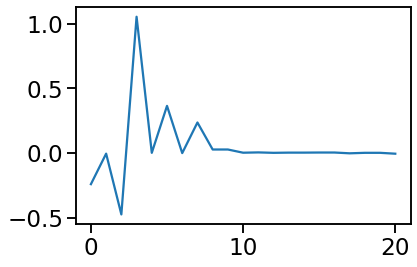

In [263]:
alpha = 0.01


#P_list = calculateTransitionAllCountries(timeSeries[timeSeries['year']>1880])
#P_allCountries = sum(P_list)/len(P_list) # average over all countries



#P = calculateTransitionProbabilitiesCountry(timeSeries,'United States')
#P = calculateTransitionProbabilitiesCountry(timeSeries,'Germany')
P_temp = (1-alpha)*P_allCountries + alpha*np.ones((21,21))/21

#sns.heatmap((P_temp))


vals, vecs = np.linalg.eig(P_temp)

vecs = vecs.real

plt.plot(vecs[0]/np.sum(vecs[0]))

In [273]:
np.sum(P_allCountries,axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])

In [158]:
vals, vecs = np.linalg.eig(P_allCountries)
zero_eigenvector = np.real(vecs.transpose()[np.argmin(np.abs(vals))])
steadyState = zero_eigenvector/np.sum(zero_eigenvector)

In [170]:
np.sum(P_allCountries,axis=0)

array([0.99932355, 1.03400784, 0.93400185, 1.12719967, 1.04055539,
       0.96233224, 0.99118759, 1.0787592 , 0.88523355, 0.98785401,
       0.92752445, 0.97523117, 0.9455845 , 0.93024703, 1.01900334,
       1.00602508, 1.01357828, 1.01441463, 1.04805073, 1.02162101,
       1.05826487])

In [181]:
vals[1]

(0.9999999999999988+0j)

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


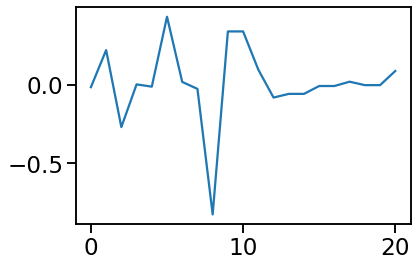

In [182]:
plt.plot(vecs[1])

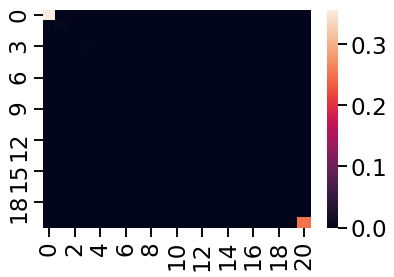

In [56]:
#alpha = 0.2


#P_list = calculateTransitionAllCountries(timeSeries[timeSeries['year']>1880])
#P_allCountries = sum(P_list)/len(P_list) # average over all countries



#P = calculateTransitionProbabilitiesCountry(timeSeries,'United States')
#P = calculateTransitionProbabilitiesCountry(timeSeries,'Germany')
#P_temp = (1-alpha)*P_allCountries + alpha*np.ones((21,21))

sns.heatmap((P_temp**100))

In [6]:
# # function to calculate the transition probabilities from one state to another

# def calculateTransitionProbabilities(timeSortedScores):
#     P=np.zeros((21,21)) # empty transition matrix
#     T=len(timeSortedScores)# number of data points
    
#     # create separate time series for each country
    
    
    
    
#     counts = np.zeros((21))
    
#     for t in range(T-1): # go over all years
#         # we ignore nan's
#         if  (timeSortedScores[t]>=0) and ((timeSortedScores[t+1]>=0)):
#             # increase the count for this year
#             P[timeSortedScores[t],timeSortedScores[t+1]] = P[timeSortedScores[t],timeSortedScores[t+1]] + 1
#             # count of occurence of transition from t for later normalisation
#             counts[timeSortedScores[t]] = counts[timeSortedScores[t]]+1
    
#     # normalise by the number of occurences of the transition
# #     for i in range(21):
# #         if counts[i]>0:
# #             P[i,:]= P[i,:]/np.sum(counts[i,:])
#     for i in range(21):
#         for i in range(21):
#             if counts[i,j]>0:

#     return(P)



# # def calculateTransitionProbabilities(timeSortedScores):
# #     P=np.zeros((21,21)) # empty transition matrix
# #     T=len(timeSortedScores)# number of data points
    
# #     counts = np.zeros((21))
    
# #     for t in range(T-1): # go over all years
# #         # we ignore nan's
# #         if  (timeSortedScores[t]>=0) and ((timeSortedScores[t+1]>=0)):
# #             # increase the count for this year
# #             P[timeSortedScores[t],timeSortedScores[t+1]] = P[timeSortedScores[t],timeSortedScores[t+1]] + 1
# #             # count of occurence of transition from t for later normalisation
# #             counts[timeSortedScores[t]] = counts[timeSortedScores[t]]+1
    
# #     # normalise by the number of occurences of the transition
# # #     for i in range(21):
# # #         if counts[i]>0:
# # #             P[i,:]= P[i,:]/np.sum(counts[i,:])
# #     for i in range(21):
# #         for i in range(21):
# #             if counts[i,j]>0:

# #     return(P)

# #timeSeries[ timeSeries['country'] == 'Germany'  ]["polity2"].values + 10)

# def calculateTransitionProbabilitiesCountry(data,country):
#     # calculate the transition probabilities for a particular country
    
#     # subset the data to only include this country, offset by ten
#     polValues = data[data['country'] == country]["polity2"].values + 10
#     # replace nans with -1
#     try:
#         polValues[np.where(np.isnan(polValues))[0][0]] = -1
#     except:
#         pass
#     # as int
#     polValues = polValues.astype(int)
    
    
#     # To implement: seperate into different regimes
    
#     # 
#     P = calculateTransitionProbabilities(polValues)
    
#     return(P)

# def calculateTransitionAllCountries(data):
#     uniqueCountries = data['country'].unique()
    
#     P_list=[]
    
#     for c in uniqueCountries:
#         P_list.append(calculateTransitionProbabilitiesCountry(data,c))
    
#     return(P_list)



In [7]:
P_list = calculateTransitionAllCountries(timeSeries)
P_allCountries = sum(P_list)/len(P_list) # average over all countries


In [8]:
P_log = np.log10(P_allCountries)

P_log[np.isinf(P_log)] = -10


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


In [9]:
np.sum(P_allCountries,axis=1)

array([0.16923077, 0.33333333, 0.26666667, 0.53846154, 0.44102564,
       0.32307692, 0.35384615, 0.36923077, 0.23076923, 0.25641026,
       0.32820513, 0.24102564, 0.22051282, 0.2       , 0.30769231,
       0.31282051, 0.31794872, 0.2974359 , 0.31282051, 0.24102564,
       0.21025641])

In [337]:
np.min(P_log)

-inf

In [341]:
P_log

array([[  -0.79975595,   -2.18231914,   -3.13744186,   -2.6469987 ,
          -3.56929084,   -4.28126069,   -4.01838839, -100.        ,
        -100.        , -100.        ,   -3.16757049, -100.        ,
        -100.        , -100.        , -100.        , -100.        ,
        -100.        , -100.        , -100.        , -100.        ,
        -100.        ],
       [  -3.43616265,   -0.55055723,   -1.6547827 ,   -2.13399189,
          -2.38668798,   -2.58006922,   -2.13755213,   -3.94324713,
          -3.315531  , -100.        ,   -2.4765388 ,   -4.0534626 ,
          -3.07583951, -100.        ,   -3.06818586,   -3.82151353,
          -3.2787536 , -100.        ,   -3.13513265, -100.        ,
          -3.06818586],
       [  -2.3152514 ,   -1.69374975,   -0.7270177 ,   -1.61931107,
          -1.75431864,   -2.86213138,   -3.65176245,   -3.92350307,
        -100.        ,   -2.76715587,   -2.26364953, -100.        ,
          -3.63245729, -100.        , -100.        ,   -3.40397796,


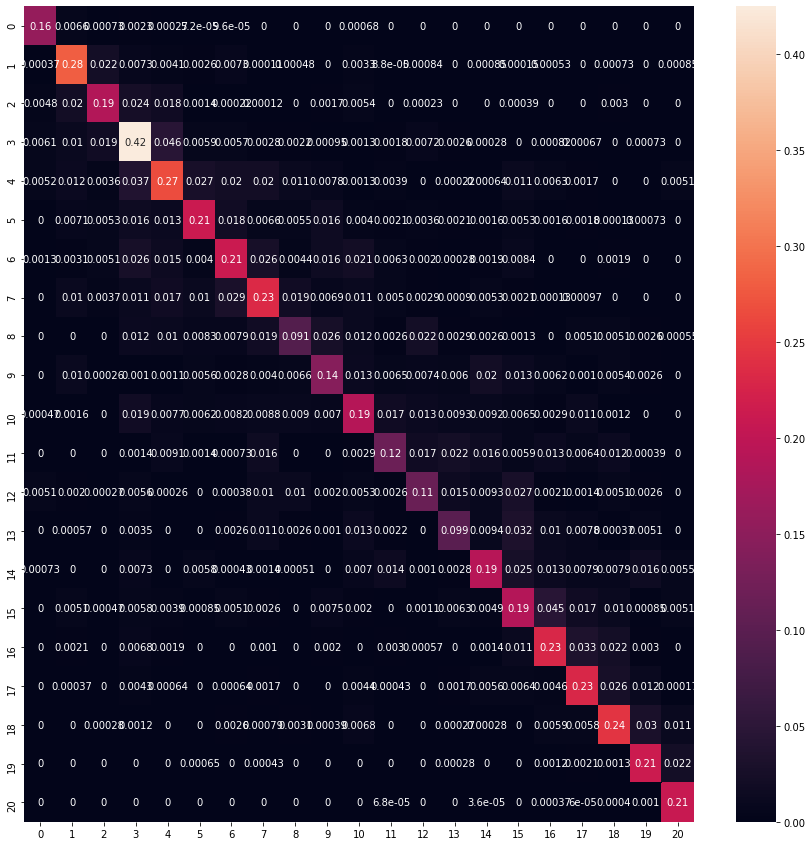

In [11]:
plt.figure(figsize=(15,15))
sns.heatmap(P_allCountries, annot=True)
plt.show()

In [12]:
P = calculateTransitionProbabilitiesCountry(timeSeries,'France')

In [13]:
np.sum(P)

18.0

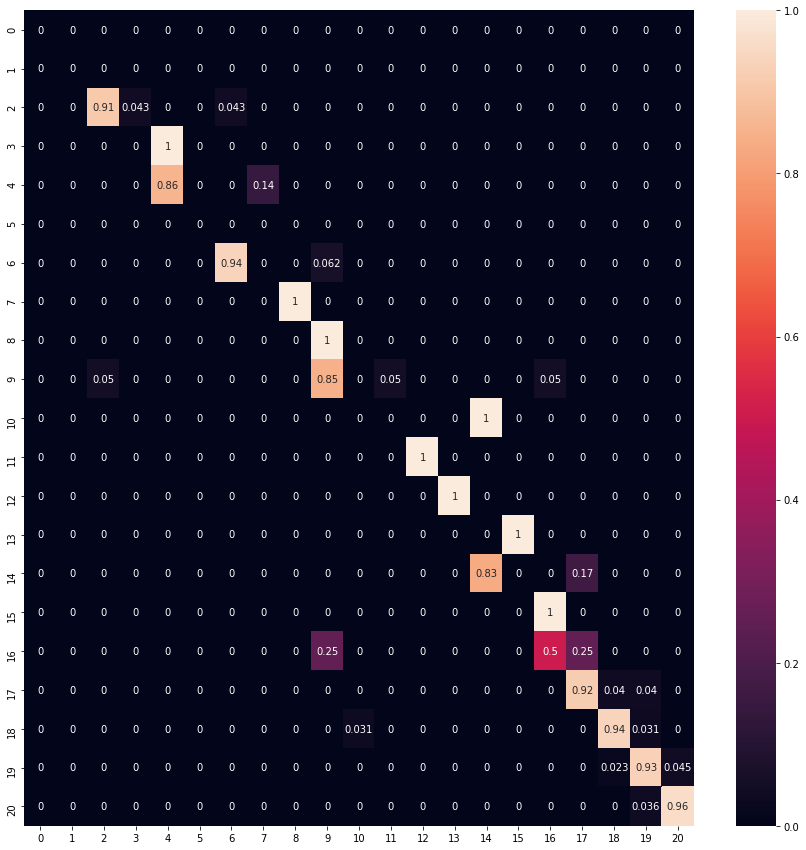

In [14]:
plt.figure(figsize=(15,15))
sns.heatmap(P, annot=True)
plt.show()

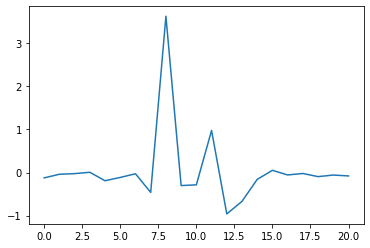

In [16]:


P_temp = P_allCountries + 0.01*np.ones((21,21))


vals, vecs = np.linalg.eig(P_temp)
zero_eigenvector = np.real(vecs.transpose()[np.argmin(np.abs(vals))])
steadyState = zero_eigenvector/np.sum(zero_eigenvector)
Pplt.plot(steadyState)

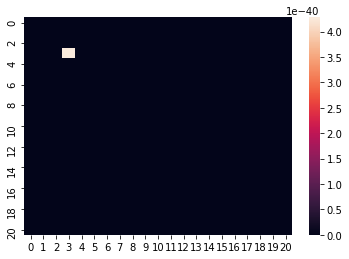

In [68]:
alpha = 0.01


P_list = calculateTransitionAllCountries(timeSeries[timeSeries['year']>1880])
P_allCountries = sum(P_list)/len(P_list) # average over all countries



#P = calculateTransitionProbabilitiesCountry(timeSeries,'United States')
#P = calculateTransitionProbabilitiesCountry(timeSeries,'Germany')
P_temp = (1-alpha)*P_allCountries + alpha*np.ones((21,21))

sns.heatmap((P_temp**100))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


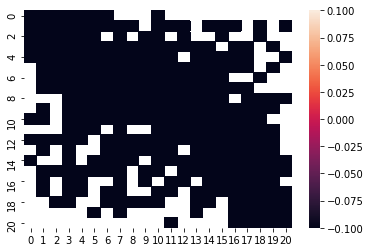

In [69]:
sns.heatmap((np.log10(P_allCountries)))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


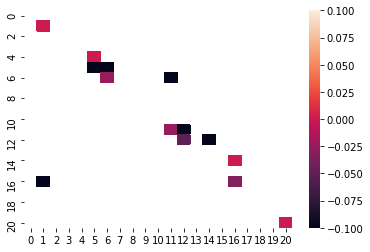

In [59]:
sns.heatmap((np.log10(P)))

In [204]:
def is_steady_state(state, Q):
    """
    Returns a boolean as to whether a given state is a steady 
    state of the Markov chain corresponding to the matrix Q
    """
    return np.allclose((state @ Q), 0)

def obtain_steady_state_numerically(
    Q, 
    max_t=100, 
    number_of_timepoints=1000
):
    """
    Solve the defining differential equation until it converges.
    
    - Q: the transition matrix
    - max_t: the maximum time for which the differential equation is solved
    - number_of_time_points: the number of time points
    """
    
    def dx(x, t):
        return x @ Q
    
    dimension = Q.shape[0]
    state = np.ones(dimension) / dimension
    
    while not is_steady_state(state=state, Q=Q):
        ts = np.linspace(0, max_t, number_of_timepoints)
        xs = odeint(func=dx, y0=state, t=ts)
        state = xs[-1]
    
    return state

In [33]:
calculateTransitionProbabilities(int(timeSeries[ timeSeries['country'] == 'Germany'  ]["polity2"].values + 10))

TypeError: only size-1 arrays can be converted to Python scalars

In [40]:
pGermany = calculateTransitionProbabilities((timeSeries[ timeSeries['country'] == 'Germany'  ]["polity2"].values + 10).astype(int))

IndexError: index -9223372036854775808 is out of bounds for axis 1 with size 21

In [284]:
germany = (timeSeries[ timeSeries['country'] == 'Germany'  ]["polity2"].values + 10)
germany[np.where(np.isnan(germany))[0][0]] = - 1
germany = germany.astype(int)

In [285]:
P = calculateTransitionProbabilities(germany)

In [289]:
np.sum(P,axis=0)

array([0.        , 1.09090909, 0.        , 0.        , 0.        ,
       1.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 1.        , 0.        , 1.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       1.        ])

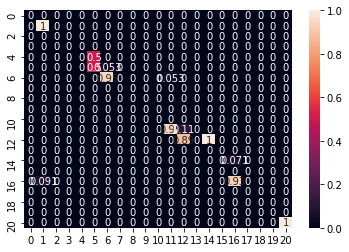

In [290]:
sns.heatmap(P, annot=True)
plt.show()

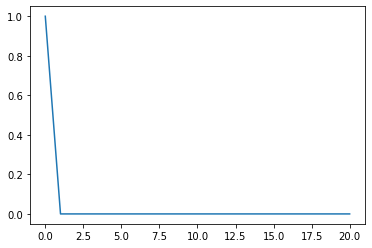

In [291]:
vals, vecs = np.linalg.eig(P.transpose())
zero_eigenvector = np.real(vecs.transpose()[np.argmin(np.abs(vals))])
steadyState = zero_eigenvector/np.sum(zero_eigenvector)
plt.plot(steadyState)

In [253]:
allCountries = (timeSeries["polity2"].values + 10)
allCountries[np.where(np.isnan(allCountries))[0][0]] = - 1
allCountries = allCountries.astype(int)

Pall = calculateTransitionProbabilities(allCountries)

In [254]:
np.max(allCountries)

20

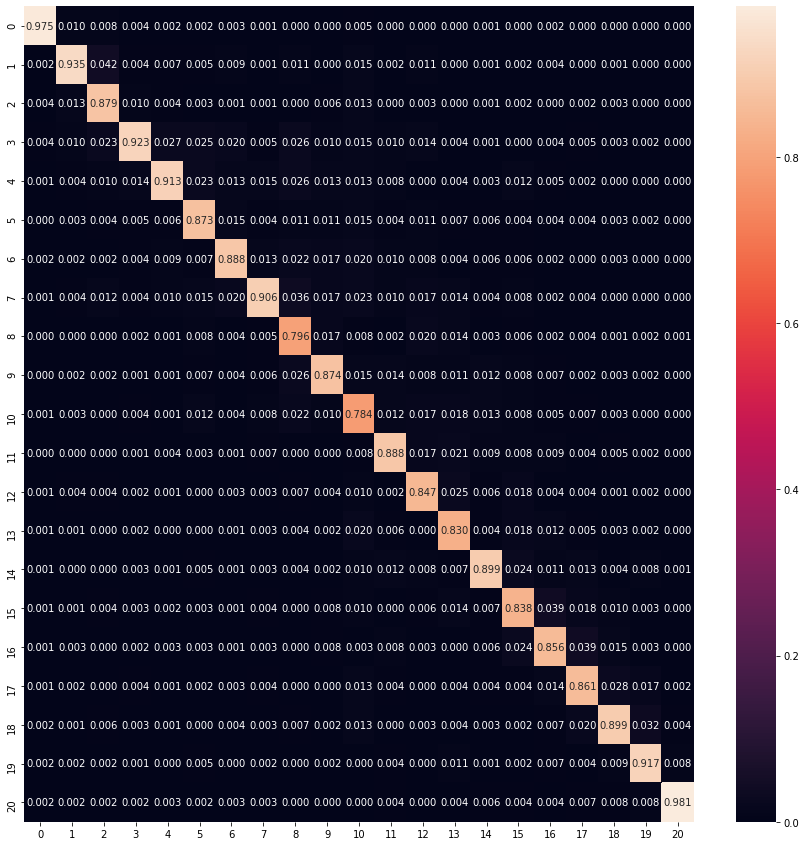

In [255]:
plt.figure(figsize=(15,15))
sns.heatmap(Pall, annot=True,fmt='.3f')
plt.show()

In [221]:
steadyState = obtain_steady_state_numerically(Pall)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in matmul


KeyboardInterrupt: 

In [273]:
sums = np.sum(Pall,axis=0)

for i in range(21):
    Pall[,:]=Pall[i,:]/np.sum(Pall[i,:])
    

In [279]:
Pall

array([[9.62839580e-01, 1.03544055e-02, 7.61451141e-03, 3.78123564e-03,
        2.20204203e-03, 1.63573320e-03, 2.51395129e-03, 8.25382503e-04,
        0.00000000e+00, 0.00000000e+00, 5.02790257e-03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.46584993e-03, 0.00000000e+00,
        1.73940644e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [2.12894185e-03, 8.86814911e-01, 4.01887340e-02, 4.14691644e-03,
        7.04375015e-03, 4.70905018e-03, 8.44353867e-03, 7.92054111e-04,
        1.03805340e-02, 0.00000000e+00, 1.44746377e-02, 1.92310095e-03,
        1.07432155e-02, 0.00000000e+00, 1.40665990e-03, 1.87369322e-03,
        3.33834074e-03, 0.00000000e+00, 1.19406646e-03, 0.00000000e+00,
        3.97855128e-04],
       [3.96136108e-03, 1.38664936e-02, 9.29990193e-01, 1.09956468e-02,
        4.71831655e-03, 3.50488636e-03, 1.34666117e-03, 8.84273751e-04,
        0.00000000e+00, 6.04843246e-03, 1.34666117e-02, 0.00000000e+00,
        2.9985

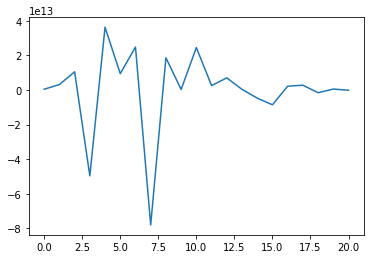

In [277]:
vals, vecs = np.linalg.eig(Pall.transpose())
zero_eigenvector = np.real(vecs.transpose()[np.argmin(np.abs(vals))])
steadyState = zero_eigenvector/np.sum(zero_eigenvector)
plt.plot(steadyState)

array([1.00224551, 1.00174672, 0.99807322, 1.00054675, 0.99925706,
       1.00165563, 0.99872774, 1.00083542, 0.99635036, 1.00190476,
       1.01272265, 1.0020284 , 0.99433428, 0.99293286, 1.        ,
       0.99604743, 0.99647887, 1.00178571, 0.99874055, 0.9984639 ,
       0.99916072])

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


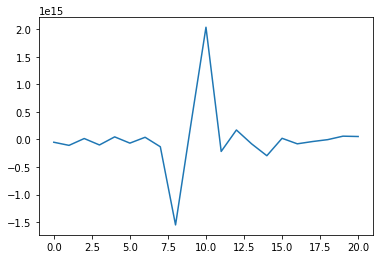

In [174]:
# stationary distribution
vals, vecs = np.linalg.eig(Pall.transpose())
zero_eigenvector = vecs.transpose()[np.argmin(np.abs(vals))]
steadyState = zero_eigenvector/np.sum(zero_eigenvector)
plt.plot(steadyState)

In [165]:
zero_eigenvector

array([-1.89239905e-02+0.j, -3.02744982e-02+0.j,  1.44333328e-02+0.j,
       -5.94461135e-02+0.j,  1.47797769e-02+0.j, -7.64563394e-02+0.j,
        5.85358143e-03+0.j, -8.58278457e-02+0.j, -3.28406336e-01+0.j,
        1.12323229e-02+0.j,  9.20487214e-01+0.j, -7.99396084e-02+0.j,
       -3.20821911e-02+0.j, -6.10978154e-02+0.j, -1.13042648e-01+0.j,
        9.66646242e-03+0.j, -2.03577494e-02+0.j, -3.49651616e-02+0.j,
       -7.24444747e-04+0.j,  2.11993711e-02+0.j,  1.15460465e-02+0.j])

In [166]:
steadyState

array([-2.79719868e-01+0.j, -4.47494338e-01+0.j,  2.13342419e-01+0.j,
       -8.78686711e-01+0.j,  2.18463290e-01+0.j, -1.13011878e+00+0.j,
        8.65231369e-02+0.j, -1.26864118e+00+0.j, -4.85424977e+00+0.j,
        1.66027554e-01+0.j,  1.36059337e+01+0.j, -1.18160578e+00+0.j,
       -4.74214264e-01+0.j, -9.03100897e-01+0.j, -1.67090945e+00+0.j,
        1.42882210e-01+0.j, -3.00912587e-01+0.j, -5.16828115e-01+0.j,
       -1.07081848e-02+0.j,  3.13352793e-01+0.j,  1.70664776e-01+0.j])

In [216]:
np.sum(Pall,axis=0)

array([1.02433076, 1.04146934, 0.93794956, 1.13703988, 1.04669068,
       0.97742306, 0.99592375, 1.09731073, 0.87002541, 0.99089861,
       0.93360087, 0.97797764, 0.94075421, 0.92358507, 1.02646394,
       0.9959669 , 1.00500277, 0.99719738, 1.03542666, 0.9962838 ,
       1.04867898])

In [134]:
Pallpyhton 

array([[9.72367438e-01, 1.04620750e-02, 7.72200772e-03, 3.82513661e-03,
        2.23048327e-03, 1.65289256e-03, 2.54777070e-03, 8.34724541e-04,
        0.00000000e+00, 0.00000000e+00, 5.02512563e-03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.48367953e-03, 0.00000000e+00,
        1.76678445e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [2.24047797e-03, 9.33740192e-01, 4.24710425e-02, 4.37158470e-03,
        7.43494424e-03, 4.95867769e-03, 8.91719745e-03, 8.34724541e-04,
        1.09890110e-02, 0.00000000e+00, 1.50753769e-02, 2.02429150e-03,
        1.13960114e-02, 0.00000000e+00, 1.48367953e-03, 1.98412698e-03,
        3.53356890e-03, 0.00000000e+00, 1.26103405e-03, 0.00000000e+00,
        4.19991600e-04],
       [3.73412995e-03, 1.30775937e-02, 8.80308880e-01, 1.03825137e-02,
        4.46096654e-03, 3.30578512e-03, 1.27388535e-03, 8.34724541e-04,
        0.00000000e+00, 5.70342205e-03, 1.25628141e-02, 0.00000000e+00,
        2.8490